# mvp-eda-edit-count-correlations

##### mariadb pass

In [14]:
mysql_user = 'bhrdwj'
# mysql_pass = input(f'Enter the MySQL password for user {mysql_user}: ')

## intro

### setup

#### plan

- Use lags of edits in some categories to predict edits in other categories
    1. get first row of pearson's correlation matrix among:
        - edit-counts in a target category by day
        - 1d-lagged-edit-counts of many other categories
    2. present treating each category as target and the others as features
    3. do this with 2013-2015. then train multi-v linreg with 2013-2015 and predict 2016.

#### imports

In [15]:
import pandas as pd, numpy as np, os, re, pyperclip, pickle
import mysql.connector as mysql, sqlalchemy
from datetime import datetime as dt

#### fonts

https://github.com/linzino7/matplotlibChinesefix

In [16]:
from matplotlib.font_manager import findfont, FontProperties  
findfont(FontProperties(family=FontProperties().get_family())) 

'/usr/share/fonts/opentype/noto/NotoSansCJK-Regular.ttc'

In [17]:
import matplotlib 
matplotlib.matplotlib_fname()

'/home/bhrdwj/anaconda3/envs/py39/lib/python3.9/site-packages/matplotlib/mpl-data/matplotlibrc'

In [18]:
import matplotlib.pyplot as plt 
plt.rcParams['font.sans-serif'] = ['Noto Sans CJK JP']  
plt.rcParams['axes.unicode_minus'] = False 

#### connect to mariadb

##### connect

In [19]:
def connect_mariadb():
    host='localhost'; user=mysql_user; passwd=mysql_pass; dbname='jawiki';
    cxn = mysql.connect(host=host,user=user,passwd=passwd, database=dbname)
    cur = cxn.cursor()

    connection_str = 'mysql+mysqlconnector://'+user+':'+passwd+'@'+host+'/'+dbname  # removed this after host +':'+dbport
    try:
        engine = sqlalchemy.create_engine(connection_str)
        conn = engine.connect()
    except Exception as e:
        print('Database connection error - check creds')
        print(e)
    return cxn, cur, engine, conn
        
cxn, cur, engine, conn = connect_mariadb()

##### test

In [20]:
metadata = sqlalchemy.MetaData(conn)
metadata.reflect()
current_tables = list(metadata.tables.keys())
current_tables

['category',
 'categorylinks',
 'cats_to_selfjoin',
 'disaster_cats_and_pages',
 'h2013',
 'h2014',
 'h2015',
 'h2016',
 'h2017',
 'h2018',
 'h2019',
 'h2020',
 'h2021',
 'page',
 't2013',
 't2014',
 't2015',
 't2016',
 't2017',
 't2018',
 't2019',
 't2020',
 't2021',
 'warn_rows']

#### some paths

In [21]:
rawdumps_path = '../data/raw/jawiki/dumps_unzipped/'
processed_path = '../data/processed/jawiki/'

## functions  
<mark>unfinished:</mark>  google translate

### simple functions to read from MySQL dumpfiles

##### function ```jpr_sql``` 

In [22]:
def jpr_sql(query, conn=conn):
    """
    Super-basic wrapper of SQLAlchemy conn.execute()
    Input:
        query string
        conn SQLAlchemy connection
    Output:
        list / result of conn.execute().fetchall()
    """
    try: 
        a = conn.execute(query)
    except Exception as e:
        print('Printing execute error:')
        print(e)
        return None
    
    try:
        return a.fetchall()
    except Exception as e:
        print('Printing results error:')
        print(e)
        print('Printing result')
        return None

##### function ```byte_read_sql```

In [23]:
def decode_if_it_can(value):
    """
    Tries to decode a possible bytes object with utf-8. 
    If fails, silently returns input.
    INPUTS: object
    OUTPUTS: input or decoded string
    """
    try:
        value = value.decode('utf-8')
    except (UnicodeDecodeError, AttributeError):
        pass
    finally:
        return value

def byte_read_sql(query, conn):
    """
    Simple wrapper for pd.read_sql() for mediawiki dumps including byte-like data.
    Inputs: 
            SQL query string
            SQLAlchemy connection
    Outputs:
            Pandas dataframe with some values modified, that is:
                values that can be decoded with .decode('utf-8') are thus decoded.
    """
    df = pd.read_sql(query, conn)
    return (df.applymap(lambda x: decode_if_it_can(x)))

### google translate / add to cache <mark> UNFINISHED </mark>

### functions to process MySQL dumpfiles

#### in cross-section

##### get_all_descendants_by_namespace

In [24]:
def get_all_descendants_by_namespace(cat_page_id:int, namespaces: list[int] = []) -> pd.DataFrame:
    """
    Get all descendant records from cats_to_selfjoin, filtered by namespace.
    Inputs:
        cat_page_id: parent-category to get descendants of
        namespaces: list of namespaces (ints) to select
            0: pages
            14: category-pages
    """
    
    
    if namespaces:
        namespace_condition = r"""
        where namespace in(""" + ", ".join(map(str,namespaces)) + r""")
        """
    else:
        namespace_condition = r" "
    
    sql = r"""
    with recursive cte (id, name, type, namespace, parent_cat_id) as (
      select     id,
                 name,
                 type,
                 namespace,
                 parent_cat_id
      from       cats_to_selfjoin
      where      parent_cat_id = """+str(cat_page_id)+r"""
      union all
      select     p.id,
                 p.name,
                 p.type,
                 p.namespace,
                 p.parent_cat_id
      from       cats_to_selfjoin p
      inner join cte
              on p.parent_cat_id = cte.id
    )
    select distinct id, name, type, namespace from cte
    """ + "".join(namespace_condition) +"""
    ;
    """
    return byte_read_sql(sql, conn)

##### create_table_where_pageid_in_list

In [25]:
def create_table_where_pageid_in_list(page_ids:list[int], newname:str = 'disaster_cats_and_pages', oldname:str = 'cats_to_selfjoin') -> None:
    jpr_sql(r"""
        create table """+newname+r""" as
        select * from """+oldname+r"""
        where id in("""+ ", ".join(page_ids) +r""")
    """, conn)
    return None

##### get_all_descendants_content_pageids

In [26]:
def get_all_descendants_content_pageids(cat_page_id:int, namespaces: list[int] = [0], tablename:str = 'disaster_cats_and_pages') -> list:
    """
    Get all descendant page_id's from tablename, content pages only by-default.
    Inputs:
        cat_page_id: parent-category to get descendants of
        namespaces: list of namespaces (ints) to select
            0: pages (DEFAULT)
            14: category-pages
    Returns:
        list of page_ids
    """
    
    
    if namespaces:
        namespace_condition = r"""
        where namespace in(""" + ", ".join(map(str,namespaces)) + r""")
        """
    else:
        namespace_condition = r" "
    
    sql = r"""
    with recursive cte (id, name, type, namespace, parent_cat_id) as (
      select     id,
                 name,
                 type,
                 namespace,
                 parent_cat_id
      from       """+ tablename +"""
      where      parent_cat_id = """+str(cat_page_id)+r"""
      union all
      select     p.id,
                 p.name,
                 p.type,
                 p.namespace,
                 p.parent_cat_id
      from       """+ tablename +""" p
      inner join cte
              on p.parent_cat_id = cte.id
    )
    select distinct id from cte
    """ + "".join(namespace_condition) +"""
    ;
    """
    return jpr_sql(sql, conn)

#### in time series

##### function to count all edits to pages in a whole timeseries table

In [27]:
def count_edits_within_pagelist_in_dumpfile(pagelist:list[int], year:int, conn=conn):
        
    stringified_pageids = ", ".join(map(str,pagelist))
    
    sql = r"""
    select
        count(row_id) as num_edits
    from h"""+str(year)+r"""
    where
        page_id in ("""+ stringified_pageids +r""")
        and event_entity = 'revision'
        and user_is_bot_by IS NULL
        and event_user_is_bot_by IS NULL
    ;
    """
    
    return pd.read_sql(sql,conn).num_edits.sum()

##### query to **explore** revisions within subcats by japanese day

In [28]:
def explore_revs_in_subcats_daily(subcat_page_ids):
    sql = """
      with formatted_date as (
        select
            date_tmstp_jp
            ,user_id
            ,user_text
            ,row_id
            ,page_id
        from h2013
        where
            page_id in ("""+ ", ".join(map(str,subcat_page_ids)) +r""")
            and event_entity = 'revision'
            and user_is_bot_by IS NULL
            and event_user_is_bot_by IS NULL
      )
      select
        date(date_tmstp_jp) as day
        ,page_id
        ,count(row_id) as num_edits
      from formatted_date
      group by day,page_id
      order by day,page_id
      ;
    """

    return pd.read_sql(sql,conn)

##### query to **count** revisions within subcats by japanese day

In [29]:
def count_revs_in_subcat_daily(subcat_name, subcat_descendant_ids:list[int], table:str) -> pd.DataFrame:
    """
    Count revision-edits of content-descendants of subcat, by day.
    """
    
    sql = """
    select
        date(date_tmstp_jp) as day
        ,count(row_id) as """+ subcat_name +r"""
    from 
        h2013
    where
        page_id in ("""+ ", ".join(map(str,subcat_descendant_ids)) +r""")
        and event_entity = 'revision'
        and user_is_bot_by IS NULL
        and event_user_is_bot_by IS NULL
    group by day
    order by day
    ;
    """
    return pd.read_sql(sql,conn) #.set_index('day')

### function to be my simple API: ```revcounts_within_page_id```

#### function takes page_id of a subcat or page, and returns df of daily edit counts

In [30]:
def revcounts_within_page_id(page_id:int) -> pd.DataFrame:
    """
    Wrapper for count_revs_in_subcat_daily
    """
    
    [title, namespace] = byte_read_sql(f"select page_title, page_namespace from page where page_id = {page_id};",conn).loc[0].tolist()
    tablename = 'h2013'
    
    if namespace == 0:
        return count_revs_in_subcat_daily(title, [page_id], tablename)
    elif namespace == 14:
        descendant_ids = subcat_content_pageids['熱帯低気圧'][page_id]
        return count_revs_in_subcat_daily(title, descendant_ids, tablename).set_index('day')
    

## unpickle

#### load pickled ```disaster_descendants```

In [31]:
with open(processed_path + 'disaster_descendants_raw.pickle', 'rb') as f:
    disaster_descendants_raw = pickle.load(f)

#### load pickled ```subcat_content_pageids```

In [32]:
with open(processed_path + 'subcat_content_pageids.pickle', 'rb') as f:
    subcat_content_pageids = pickle.load(f)

#### load pickled ```subcat_edit_counts```

In [65]:
with open(processed_path + 'subcat_edit_counts.pickle', 'rb') as f:
    subcat_edit_counts = pickle.load(f)

## get lists of pageids in subcats   
**pickled for disasters:** ```subcat_content_pageids```

### clean disaster_descendants

#### some globals

In [33]:
disaster_cat_page_ids = {'火山災害':2390743, '熱帯低気圧':626482, '雪害':2390774, '地震':135264, '津波':765772}  # '自然災害':137069, 
disasters_english = {'火山災害':'VolcanicDisaster', '熱帯低気圧':'TropicalCyclones', '雪害':'SnowDamage', '地震':'Earthquake', '津波':'Tsunami'}
disasters = list(disaster_cat_page_ids.keys())

#### drop rows with duplicate category name for the same category page_id

In [34]:
disaster_descendants = {}
for i in disaster_descendants_raw:
    disaster_descendants[i] = disaster_descendants_raw[i].drop_duplicates(subset='id')

### get descendants

#### get all descendents of subcats

In [35]:
disaster_descendants_all = pd.concat((disaster_descendants[i] for i in disaster_descendants), axis='rows')

#### create table disaster_cats_and_pages with just subcat-descendant rows

#### get disaster subcategories ```disaster_subcats```

In [36]:
disaster_subcats = {}
for i in disaster_descendants:
    disaster_subcats[i] = disaster_descendants[i][lambda x: x.type == 'subcat']

In [37]:
disaster_subcats['火山災害']

,id,name,type,namespace
20,2884010,にほん\n日本の火山災害,subcat,14
68,3477562,しほうしたしんふつ\n火山災害で死亡した人物,subcat,14


#### get subset of content-page page_ids that are in each disaster subcat

##### get **(already pickled)**

##### peek

In [38]:
subcat_content_pageids.keys()

dict_keys(['火山災害', '熱帯低気圧', '雪害', '地震', '津波'])

In [39]:
[len(subcat_content_pageids[i]) for i in list(subcat_content_pageids.keys())]

[2, 148, 2, 561, 232]

In [40]:
subcat_content_pageids['火山災害'].keys()

dict_keys([2884010, 3477562])

In [41]:
len(subcat_content_pageids['火山災害'][2884010])

27

##### pickle

## get annual counts of edits in cats (done for disasters)

#### Count edits to pages in 2013

##### get counts (done for disasters - see ```big_cyclone_cats```)

In [71]:
# subcat_edit_counts = {}
for disaster in ['地震']: # disaster_subcats:
    subcat_edit_counts[disaster] = {}
    for subcat in disaster_subcats[disaster].id:
        try:
            subcat_edit_counts[disaster][subcat] = (
                count_edits_within_pagelist_in_dumpfile(
                    subcat_content_pageids[disaster][subcat], 
                    2013
                )
            )
        except:
            subcat_edit_counts[disaster][subcat] = None

##### peek

In [73]:
list(disaster_subcats.keys())

['火山災害', '熱帯低気圧', '雪害', '地震', '津波']

In [74]:
list(subcat_edit_counts.keys())

['火山災害', '熱帯低気圧', '雪害', '地震', '津波']

In [75]:
list(map(lambda x: len(subcat_edit_counts[x]), list(subcat_edit_counts.keys())))

[2, 148, 2, 561, 232]

##### pickle

## count edits by-day

In [48]:
df = pd.concat([revcounts_within_page_id(i) for i in big_cyclone_cats], axis="columns").sort_index()
df = df.fillna(0)
df = df.resample('D').sum().fillna(0)

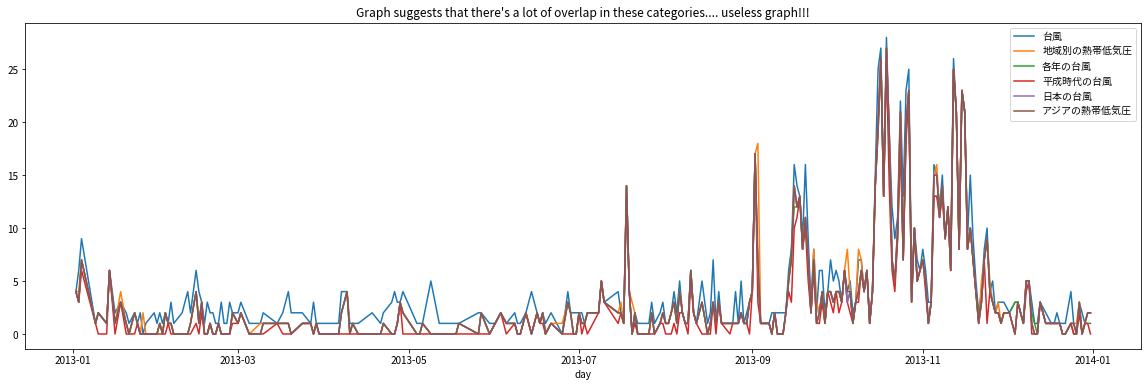

In [84]:
fig = plt.figure()
ax = fig.gca()
df.plot(figsize=(20,6), ax=ax)
ax.set_title("Graph suggests that there's a lot of overlap in these categories.... useless graph!!!")
plt.show()

### end section

# END